# Repeater Code bit flip

This program aims to simulate a quantum repeater code. We analyze the percentage of errors as a function of the number of qubits.

In [105]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


In [106]:
#secondary modules
import numpy as np
import matplotlib.pyplot as plt

## Single qubit stability

### Circuit creation

Simple qubit measurement, to look at the error percentage on a single qubit.

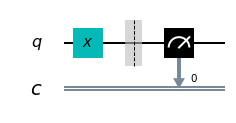

In [107]:
circ_single = QuantumCircuit(1,1)

#induced artificial error
circ_single.x(0)

circ_single.barrier(0)

circ_single.measure(0,0)

circ_single.draw()

### Simulating single qubit gate

In [108]:
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
shots = 2048
job_sim = execute(circ_single, backend_sim, shots=shots)

# Grab the results from the job.
result_sim = job_sim.result()

counts_single = result_sim.get_counts(circ_single)
print(counts_single)

{'1': 2048}


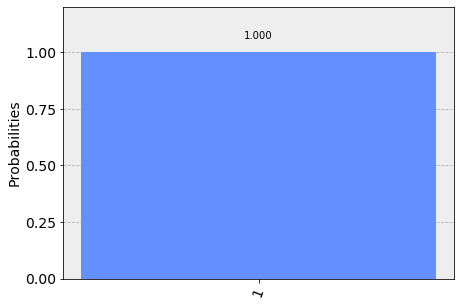

In [109]:
plot_histogram(counts_single)

### Simulating on a real machine

In [110]:
shots_exp_single = 2048

backend = provider.get_backend('ibmq_vigo')
job_exp_single = execute(circ_single, backend=backend, shots = shots_exp_single)
job_monitor(job_exp_single)

Job Status: job has successfully run


In [111]:
result_exp_single = job_exp_single.result()

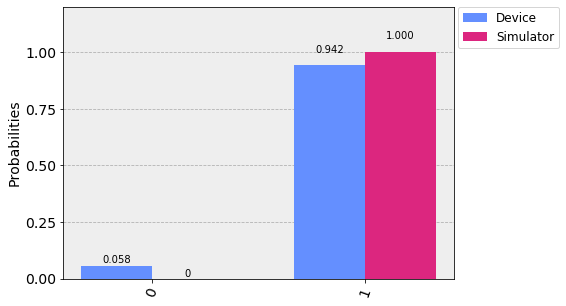

In [113]:
counts_exp_single = result_exp_single.get_counts(circ_single)
plot_histogram([counts_exp_single,counts_single], legend=['Device', 'Simulator'])

In [166]:
ExpSingleOut = list(counts_exp_single.items())[1]

Err_single = 1-ExpSingleOut[1]/shots_exp

print('There is ',Err_single*100,'percent of errors.')

There is  5.76171875 percent of errors.


## Three qubits code

### Circuit creation

Here we first encode the qubit in the state |000>+|111>

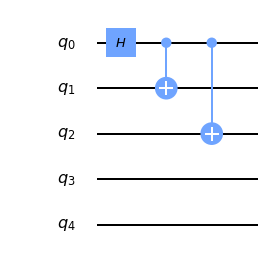

In [136]:
circ = QuantumCircuit(5)

#Induced flip errors 
circ.h(0)

circ.cx(0,1)
circ.cx(0,2)

circ.draw()

We now add the Z1Z2 and Z2Z3 measurements measured on syndrome qubits 3 and 4.

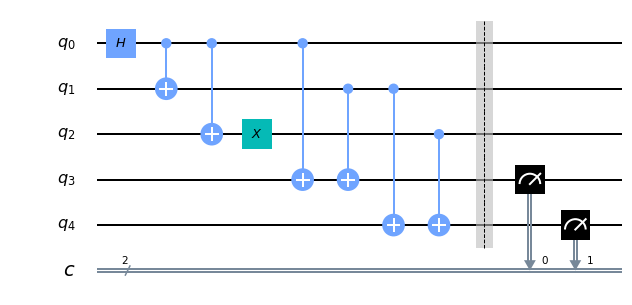

In [137]:
#Measure barrier (Not really useful but nice for the eyes)
meas = QuantumCircuit(5,2)
meas.barrier(range(5))

#Induced error(s)
circ.x(2)

#Z1Z2 Measurements
circ.cx(0,3)
circ.cx(1,3)

#Z2Z3 Measurements
circ.cx(1,4)
circ.cx(2,4)
# map the quantum measurement to the classical bits
meas.measure(3,0)
meas.measure(4,1)

# The Qiskit circuit object supports composition using
# the addition operator.
qc = circ+meas

#drawing the circuit
qc.draw()

## Simulating on the quantum simulator

In [138]:
backend_sim = Aer.get_backend('qasm_simulator')

shots = 2048
job_sim = execute(qc, backend_sim, shots=shots)

# Grab the results from the job.
result_sim = job_sim.result()

#The dictionary counts summarize all the possible output with the number of occurence per state.
counts = result_sim.get_counts(qc)
print(counts)

{'10': 2048}


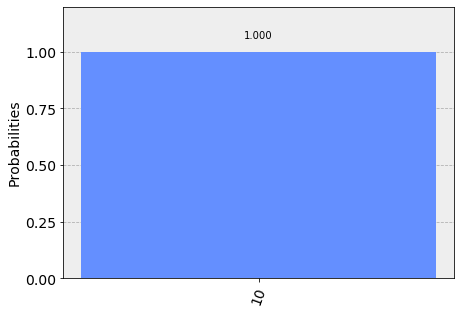

In [139]:
plot_histogram(counts)

## Expected result for single errors

|| Err_Qubit1        | Err_Qubit2        | Err_Qubit3  |
|------------| :-------------:|:-------------:| :-----:|
| Output State | 01     | 11 | 10 |

## Automatic detection (Classical correction) for a single spin flip error

We only analyze for the simulator, with artificially induced errors. In our case without any errors we should be observing |00>. But we have induced a single bit flip on the first spin, hence we should be observing |10> in the IBM choice of basis...

In [140]:
SimuOut = list(counts.items())[0]
#print(SimuOut)

###Correction###

if SimuOut[0] == '00':
    print('|00> No errors induced.')
elif SimuOut[0] == '01':
    print('|01> The first qubit is flipped.')
elif SimuOut[0] == '10':
    print('|10> The last qubit is flipped.')
else:
    print('|11> There is an error on the middle qubit.')

|10> The last qubit is flipped.


## Running the code on a real machine

In [141]:
provider = IBMQ.get_provider(group='open')
provider.backends()


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [142]:
shots_exp = 2048

backend = provider.get_backend('ibmq_vigo')
job_exp = execute(qc, backend=backend, shots = shots_exp)
job_monitor(job_exp)

Job Status: job has successfully run


In [143]:
result_exp = job_exp.result()

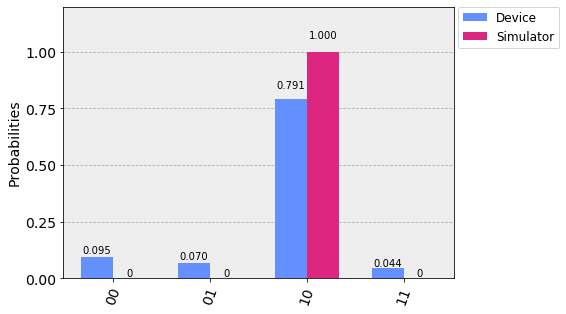

In [144]:
counts_exp = result_exp.get_counts(qc)
plot_histogram([counts_exp,counts], legend=['Device', 'Simulator'])

In [145]:
print(counts_exp)

{'10': 1620, '11': 90, '00': 195, '01': 143}


In [146]:
print(counts)

{'10': 2048}


## Data Analysis

Let's suppose all of our spins start in the state |000> and we induce errors manually using X gates.

In [147]:
#Case for 0 or all bit flips
P_00 = counts_exp['00']/shots_exp*100
P_01 = counts_exp['01']/shots_exp*100
P_10 = counts_exp['10']/shots_exp*100
P_11 = counts_exp['11']/shots_exp*100


print('There is ',P_00,'percent chance that either all the spins remained in their initial states or a small chance that they all flipped.')
print('There is ',P_01,'percent chance that either the last spin flipped or that the first two flipped.')
print('There is ',P_10,'percent chance that either the first spin flipped or that the last two flipped.')
print('There is ',P_11,'percent chance that either the middle spin flipped or that the first one and the last one flipped.')

There is  9.521484375 percent chance that either all the spins remained in their initial states or a small chance that they all flipped.
There is  6.982421875 percent chance that either the last spin flipped or that the first two flipped.
There is  79.1015625 percent chance that either the first spin flipped or that the last two flipped.
There is  4.39453125 percent chance that either the middle spin flipped or that the first one and the last one flipped.


## Error

In [148]:
SimuRes = list(counts.items())[0]

print('If the machine was perfect we would have expected to observe a|',SimuRes[0],'>state.')



Err = 100 - P_01 #Change that to a more general case.


print('There is',Err,'percent of error on this machine.')

If the machine was perfect we would have expected to observe a| 10 >state.
There is 93.017578125 percent of error on this machine.


## Running the simulation on an other computer

In [149]:
#Autre computer
shots_exp = 2048

backend = provider.get_backend('ibmqx2')
job_exp = execute(qc, backend=backend, shots = shots_exp)
job_monitor(job_exp)
result_exp = job_exp.result()

Job Status: job has successfully run


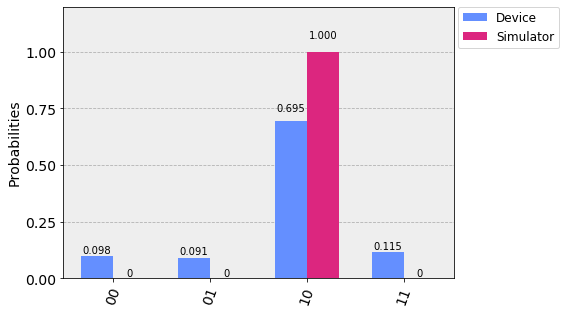

In [150]:
counts_exp = result_exp.get_counts(qc)
plot_histogram([counts_exp,counts], legend=['Device', 'Simulator'])

The behaviour of this computer is a bit weird, if I launch the code at different times of the day I will obtain completely different results